In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import circlify
import requests
from PIL import Image
from io import BytesIO
from pyfonts import load_bunny_font
from drawarrow import ax_arrow

In [2]:
apod = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2026/2026-01-20/apod.csv")

In [3]:
# Replace \n values with a whitespace
apod["copyright"] = apod["copyright"].str.replace("\n", " ", regex=False)

In [4]:
# Filter for image media type
df_image = apod[apod["media_type"]=="image"]

In [5]:
# Filter for Portugal and select relevant columns
pt = (
    df_image[df_image["explanation"].str.contains("Portugal")]
    .reset_index()
    [["copyright", "title", "url"]]
)

In [6]:
# Function to update some values of copyright column
def update_credits(df):
    updates = {0: "Kees Scherer",
               8: "Zarcos Palma",
               2: "Miguel Claro",
               5: "Miguel Claro",
               10: "Miguel Claro",
               20: "Miguel Claro"}

    for i, row in df.iterrows():
        if i in updates:
            df.at[i, "copyright"] = updates[i]

    return df

# Apply the function
pt_updated = update_credits(pt)

In [7]:
# Remove trailing whitespaces
pt_updated["copyright"] = pt_updated["copyright"].str.strip()

In [8]:
# Group and count values
pt_count = pt_updated.groupby(["copyright", "title"])["title"].value_counts().reset_index().sort_values("count", ascending=False, ignore_index=True)

In [9]:
# Merge dataframes, slice off duplicate titles, sort by count
df = (
    pd.merge(pt_updated, pt_count, on=["copyright", "title"], how="right")[2:]
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)        

In [10]:
df

,copyright,title,url,count
0,Miguel Claro,Rainbow Airglow over the Azores,https://apod.nasa.gov/apod/image/1603/GravityW...,3
1,Benjamim Ribeiro,Young Moon Meets Evening Star,https://apod.nasa.gov/apod/image/1112/IMG_1552...,1
2,David Cruz,The Road and the Milky Way,https://apod.nasa.gov/apod/image/2206/MilkyWay...,1
3,Kees Scherer,Andromeda before Photoshop,https://apod.nasa.gov/apod/image/1910/M31Befor...,1
4,Marcin Rosadziński,Stairway to the Milky Way,https://apod.nasa.gov/apod/image/2405/Stairway...,1
5,David Cruz,Jupiter and the Meteors from Gemini,https://apod.nasa.gov/apod/image/2512/Geminids...,1
6,Miguel Claro,Andromeda in a Single Shot,https://apod.nasa.gov/apod/image/2106/Andromed...,1
7,Miguel Claro,"Bright Meteor, Starry Sky",https://apod.nasa.gov/apod/image/2108/BrightMe...,1
8,Miguel Claro,From Moonrise to Sunset,https://apod.nasa.gov/apod/image/0811/Panorami...,1
9,Miguel Claro,Crescent Moon and Planets Over Portugal,https://apod.nasa.gov/apod/image/1008/sandplan...,1


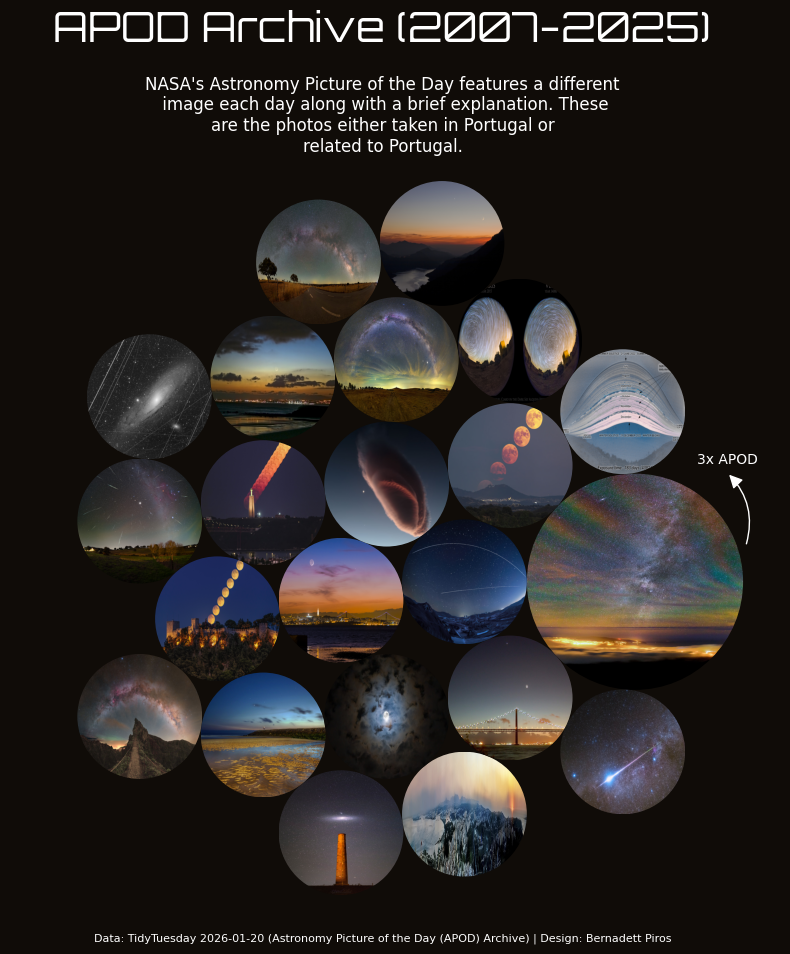

In [11]:
# Load custom font
font = load_bunny_font("Orbitron")

# Calcualte circle positions
circles = circlify.circlify(
    df["count"].tolist(),
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Reverse the order of the circles to match the dataframe
circles = circles[::-1]

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# loop through the circles and row data pairs
for circle, (index, data) in zip(circles, df.iterrows()):
    x, y, r = circle.x, circle.y, circle.r

    # Retrieve data from the url
    image_data = requests.get(data["url"])
    # Open image and convert the colors to RGB
    img = Image.open(BytesIO(image_data.content)).convert("RGB")

    # Plot image 
    im = ax.imshow(
        img,
        extent=(x - r, x + r, y - r, y + r),
        zorder=2
    )

    # Clip image to circle 
    clip_circle = patches.Circle((x, y), r, transform=ax.transData)
    im.set_clip_path(clip_circle)        

# Axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r + 0.1,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# Annotation
arrow_dict = dict(width=1, radius=0.3, color="white")

ax_arrow(
    head_position=[0.9, 0.2],
    tail_position=[0.95, 0],
    **arrow_dict  
    )

ax.text(0.9, 0.225, "3x APOD", color="white", ha="center")

# Remove the axis
ax.axis("off")

# Set background color
fig.set_facecolor("#100C08") # Smoky black

# Add titles
fig.text(0.5, 1, "APOD Archive (2007-2025)", color="white", size=30, font=font, ha="center")
fig.text(0.5, 0.89, "NASA's Astronomy Picture of the Day features a different\n image each day along with a brief explanation. These\nare the photos either taken in Portugal or\nrelated to Portugal.", color="white", size=12, ha="center")

# Add caption
fig.text(0.5, 0.1, "Data: TidyTuesday 2026-01-20 (Astronomy Picture of the Day (APOD) Archive) | Design: Bernadett Piros", color="white", size=8, ha="center")

plt.show()

# Save figure
#fig.savefig("2026-01-20.png", bbox_inches="tight", pad_inches=0.2)